# Práctica Final

## Clasificación del género de una persona a partir de la morfologíade la zona ocular con DenseNet

### Alumnos:
Jacobo Casado de Gracia

Ignacio Sánchez Herrera

La base de datos con la que se va a trabajar es con una base de datos de ojos de hombres y mujeres; al ser un problema de clasificación binaria, hay 2 carpetas en la carpeta principal, 1 por cada clase.

Para descargar la base de datos en formato .zip, que es como se ha trabajado con este cuaderno, se dejan dos enlaces a continuación, uno de la consigna de la UGR, como así lo ha pedido el profesor, y otro en google Drive, donde la duración del enlace es de más de 1 mes.

Enlace consigna UGR : https://consigna.ugr.es/f/7o98JLIkcWEjaQ8Q/eyes.zip


Enlace drive: https://drive.google.com/file/d/1Et6Pba6Y7aTYwRKmvZCVOYPTtItDruA4/view?usp=sharing

A continuación, se ha trabajado subiendo previamente el archivo "eyes.zip" proporcionado anteriormente a la carpeta raíz de google Drive; si se trabaja en local, habría que sustituir las siguientes líneas por una ruta local. Se recomienda subir el archivo "eyes.zip" al directorio raíz de google Drive y ejecutar las acciones de montado y lectura que hay a continuación, para evitar problemas.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/eyes.zip" -d "/content/eyes"

In [ ]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, AveragePooling2D
from keras.layers import BatchNormalization, Activation
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input


import pandas as pd
from glob import glob
import cv2
from tqdm import tqdm
import os

print(tf.__version__)

2.7.0


In [ ]:
# Constantes para el resto del programa
image_size = 75
channels = 3
seed = 42

Definimos la función para mostrar la evolución del entrenamiento de los modelos

In [ ]:
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.legend(['Training loss', 'Validation loss'])
    pyplot.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.legend(['Training accuracy','Validation accuracy'])
    pyplot.show()

Creamos los set de entrenamiento y validación obteniendo las imágenes con la función de keras *image_dataset_from_directory* la cual obtiene las imágenes por lotes de manera aleatoria.

Usamos inicialmente el 30% para validación y el 70% para entrenamiento

In [ ]:
PATH = "/content/eyes/"
train_dir = os.path.join(PATH)
# Coge las imagenes por lotes, el tamaño por defecto del lote es de 32
train = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=(0.3),
        subset="training",
        seed=seed,
        image_size=(image_size,image_size)
    )
validation = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=(0.3),
        subset="validation",
        seed=seed,
        image_size=(image_size,image_size)
    )

Found 11525 files belonging to 2 classes.
Using 8068 files for training.
Found 11525 files belonging to 2 classes.
Using 3457 files for validation.


Mostramos algunas imágenes de nuestro dataset

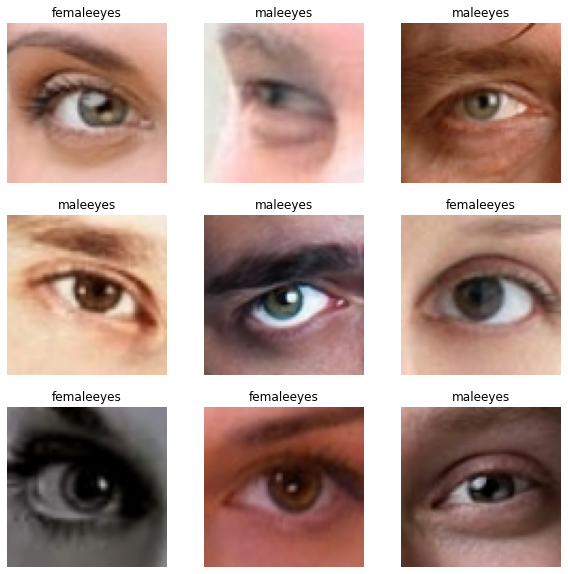

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])
        plt.axis(False)
plt.show()

Queremos un 20% en validación y un 10% en test, por lo que del 30% de validación cogemos 1/3 para test (en total un 10% de test, 20% de validación)

In [ ]:
# Obtenemos el número de lotes iniciales para validación (el 30% del total)
val_batches = tf.data.experimental.cardinality(validation)
# Nos quedamos con 2/3 de esos lotes para test (el 20% del total)
test_batches = int( float(val_batches) * (2/3) )
test = validation.take(test_batches)
# Quitamos esos 2/3 de la validación para quedarnos con un 10% en validación 
# y 20% en test
validation = validation.skip(test_batches)

print('Número de lotes de validación: %d' % tf.data.experimental.cardinality(validation))
print('Número de lotes de test: %d' % tf.data.experimental.cardinality(test))

Número de lotes de validación: 37
Número de lotes de test: 72


Función para cargar la red DenseNet que queramos, ya que haremos pruebas con las 3 redes que nos proporciona Keras.

In [ ]:
def cargaDenseNet(dense_type = 'densenet121'):
    densenet = None
    if(dense_type == 'densenet121'):
        densenet = DenseNet121(
            input_shape=(image_size, image_size, channels),
            include_top = False,
            weights="imagenet",
            pooling="avg"
        ) 
    elif(dense_type == 'densenet169'):
        densenet = DenseNet169(
            input_shape=(image_size, image_size, channels),
            include_top = False,
            weights="imagenet",
            pooling="avg"
        ) 
    elif(dense_type == 'densenet201'):
        densenet = DenseNet201(
            input_shape=(image_size, image_size, channels),
            include_top = False,
            weights="imagenet",
            pooling="avg"
        )
    return densenet

## Trasfer learning solo con una capa de clasificación

Para evitar superar la memoria, el código se ha organizado en métodos, con lo que conseguimos que la memoria usada se elimine al finalizar el método.

Primero obtendremos un extractor de características, para ello primero debemos cargar la red DenseNet y congelarla por completo. Una vez tenemos la red, creamos nuestro modelo en el que introduciremos una capa de preprocesado de datos antes de DenseNet y la capa de clasificación al final de la red.

La capa de clasificación tendrá una función de activación sigmoidal ya que estamos ante un problema de clasificación binaria.

El modelo se compilará usando la función de pérdida **binary crossentropy**, puesto que es clasificación binaria y un optimizador de Adam.

In [ ]:
def model_frozen_only_classifier(epochs, dense_type):
    
    # Cargamos la red DenseNet
    densenet = cargaDenseNet(dense_type)

    #Congelamos la red
    densenet.trainable = False

    # Añadimos la capa de preprocesado de entrada antes de DenseNet
    # y la de clasificación tras la de DenseNet 
    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train,
        epochs = epochs,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')

    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del model, score, hist, densenet

    

A continuación ejecutamos 3 veces el método para comparar los resultados obtenidos con los distintos tamaños de DenseNet.

In [ ]:
model_frozen_only_classifier(10, 'densenet121')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                           

RESULTADOS EN TEST:
Pérdida en test: 0.24099892377853394
Accuracy en test: 0.9032118320465088


51888128/51877672 [==============================] - 9s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642

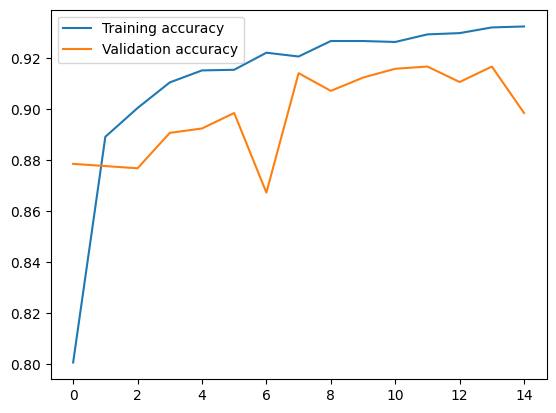

RESULTADOS EN TEST:
Pérdida en test: 0.2417413592338562
Accuracy en test: 0.90234375


In [ ]:
model_frozen_only_classifier(10, 'densenet169')

74850304/74836368 [==============================] - 14s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              1832

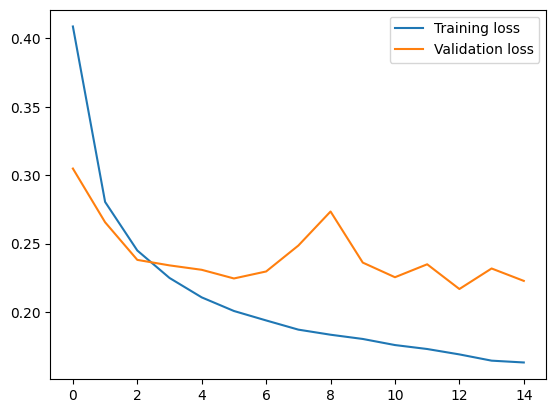

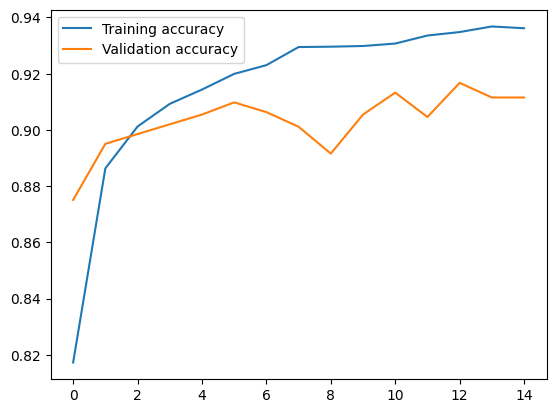

RESULTADOS EN TEST:
Pérdida en test: 0.21623530983924866
Accuracy en test: 0.9184027910232544


In [ ]:
model_frozen_only_classifier(10,'densenet201')

## Fine tuning - SGD
A continuación realizaremos fine-tuning partiendo del extractor de características obtenido en el punto anterior, descongelando el último bloque denso.

Para realizar fine-tuning:
1. Se entrenará SOLO la capa de clasificación durante unas pocas épocas
2. Se descongelará el último bloque denso de la red DenseNet, el cual contiene todas las capas en las que aparezaca 'conv5'
3. Se volverá a entrenar el modelo comenzando por la época en la que terminó el entrenamiento del clasificador del punto 1

En este modelo, para la parte de fine-tuning, una vez descongelada el último bloque *denso*, usaremos como función de optimización la función de *Stochastic Gradient Descent* con un learning rate de 0.001 aplicando un momentum de *Nesterov* de 0.9.

Se han elegido estos parámetros y esta función de optimización porque es la que se usa en el entrenamiento de DenseNet con ImageNet en las últimas épocas, según el paper oficial.

### Fine-tuning sin aumento de datos

In [ ]:
def model_defrost_conv5_lr_SGD(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if 'conv5' in layer.name:
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001
                                            , nesterov = True
                                            , momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist = model.fit(
        train,
        epochs = total_epochs,
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')

    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])


    del model, score, hist, densenet

A continuación ejecutaremos el método 3 veces, para comparar los resultados obtenidos dependiendo del tamaño de DenseNet.

In [ ]:
model_defrost_conv5_lr_SGD(10, 20, 'densenet121')

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                              

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_11 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                           

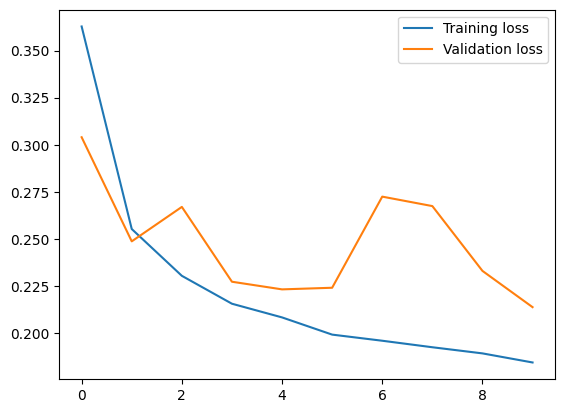

RESULTADOS EN TEST:
Pérdida en test: 0.22725793719291687
Accuracy en test: 0.9153645634651184
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_11 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet169 (Functional)    (N

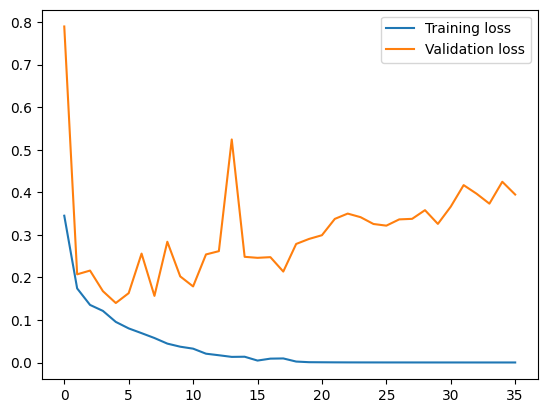

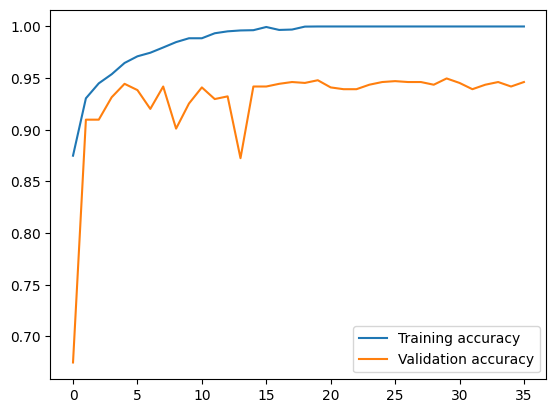

RESULTADOS EN TEST:
Pérdida en test: 0.2896791696548462
Accuracy en test: 0.9544270634651184


In [ ]:
model_defrost_conv5_lr_SGD(10, 20, 'densenet169')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                           

RESULTADOS EN TEST:
Pérdida en test: 0.21831178665161133
Accuracy en test: 0.9079861044883728
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (N

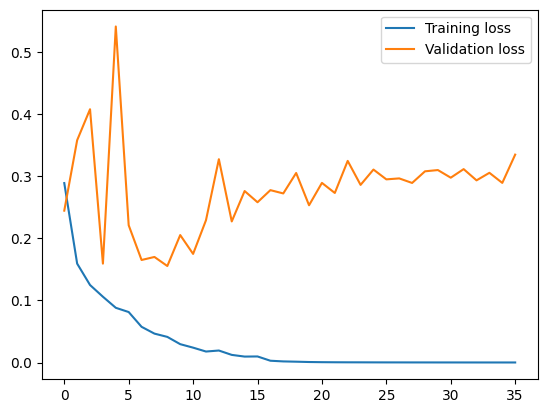

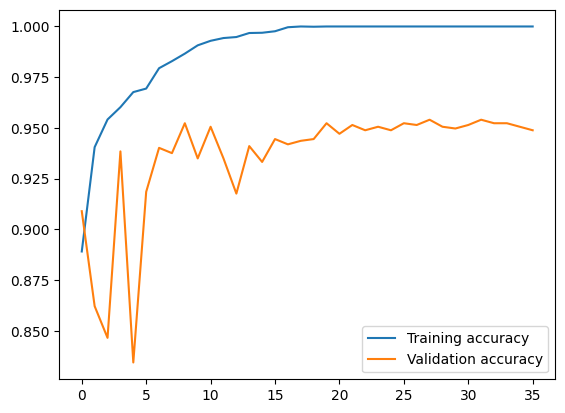

RESULTADOS EN TEST:
Pérdida en test: 0.24011768400669098
Accuracy en test: 0.9583333134651184


In [ ]:
model_defrost_conv5_lr_SGD(10, 20, 'densenet201')

### Fine-tuning con aumento de datos
Usaremos data augmentation para disminuir el overfitting y mejorar el aprendizaje, y *checkpoints* ya que aparecen picos en la validación y nos interesa quedarnos con los pesos de la época en la que obtenemos la mínima pérdida.

Aquí podemos ver un ejemplo de las imagenes generadas con aumento de datos.
Las modificaciones realizadas han sido efecto espejo y una rotación del 10% aleatoria.

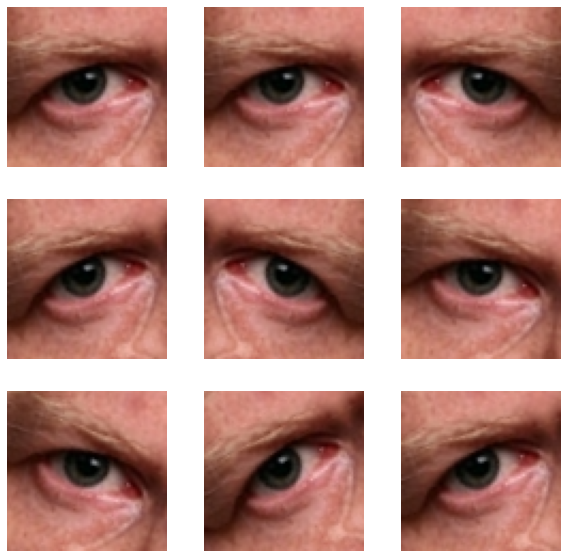

In [ ]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

for image, _ in train.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
plt.show()

Al estar trabajando con datasets de tensorflow que funcionan generando batches, para aplicar aumento de datos, lo haremos usando el método `dataset.map` solo sobre el dataset de train, para que las transformaciones solo se apliquen a este. Esto nos devolverá un nuevo generador de lotes (`dataset`) que aplicará las transformaciones a las imágenes que genere.

In [ ]:
def model_defrost_conv5_data_augmentation_lr_SGD(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    # Generamos un checkpoint
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    # Descongelamos la última capa densa
    for layer in my_layer.layers:
        if 'conv5' in layer.name:
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Compilamos el modelo
    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=0.001,
            nesterov = True,
            momentum = 0.9
        ),
        metrics=["accuracy"]
    )

    model.summary()

    # Entrenamos el modelo
    hist_fine = model.fit(
        train_aug,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    # Cargamos los pesos del checkpoint
    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])
    
    # model.save(dense_type + '-I.h5')


    del model, score, hist, densenet, hist_fine

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                              

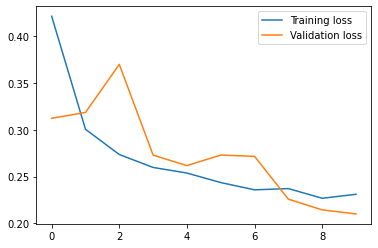

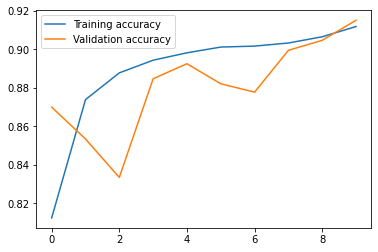

RESULTADOS EN TEST:
Pérdida en test: 0.22115831077098846
Accuracy en test: 0.9157986044883728
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                 

In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD(10, 35, 'densenet201')

## Aumento del número de capas descongeladas

A continuación comprobaremos la mejora qe se puede obtener aumentando el número de capas descongeladas. 

( El código de los próximos métodos es siempre igual, solo aumenta el número de capas descongeladas ya que se descongelan más bloques convolucionales progresivamente )

### Descongelamos los 2 últimos bloques densos (conv5, conv4)

In [ ]:
def model_defrost_conv5_data_augmentation_lr_SGD_II(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if ('conv4' in layer.name) or ('conv5' in layer.name) :
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False


    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True, momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train_aug,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])
    
    # model.save(dense_type + '-II.h5')


    del model, score, hist, densenet, hist_fine

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_30 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_15 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_31 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                          

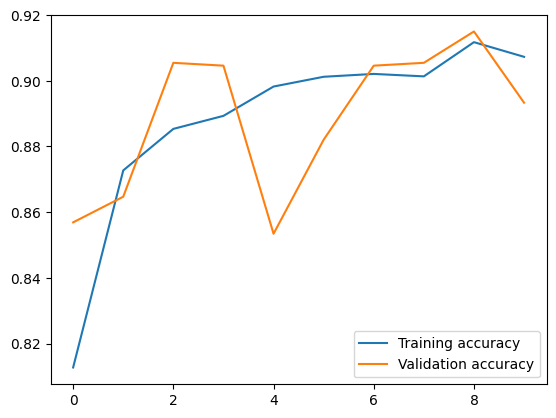

RESULTADOS EN TEST:
Pérdida en test: 0.24457420408725739
Accuracy en test: 0.8958333134651184
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_30 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_15 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.truediv_31 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 densenet201 (Functional)    (

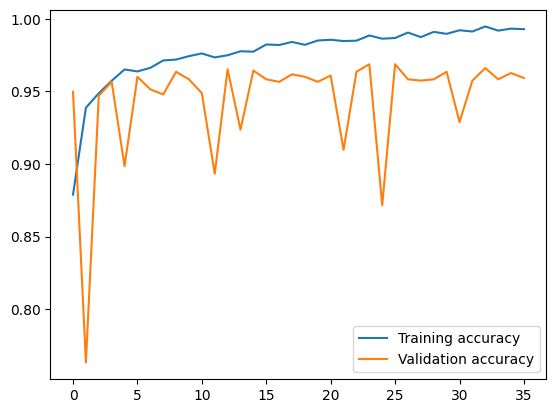

RESULTADOS EN TEST:
Pérdida en test: 0.09071847796440125
Accuracy en test: 0.9696180820465088


In [ ]:
model_defrost_conv5_data_augmentation_lr_SGD_II(10, 35, 'densenet201')

### Descogelamos los 3 últimos bloques densos (conv5, conv4, conv3)

In [ ]:
def model_defrost_data_augmentation_lr_SGD_III(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if ('conv4' in layer.name) or ('conv5' in layer.name) or ('conv3' in layer.name):
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True, momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train_aug,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])
    
    # model.save(dense_type + '-III.h5')


    del model, score, hist, densenet, hist_fine

74850304/74836368 [==============================] - 14s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              1832

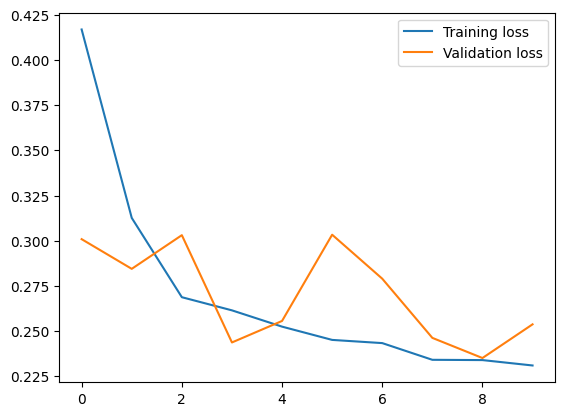

RESULTADOS EN TEST:
Pérdida en test: 0.2509418725967407
Accuracy en test: 0.8932291865348816
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (No

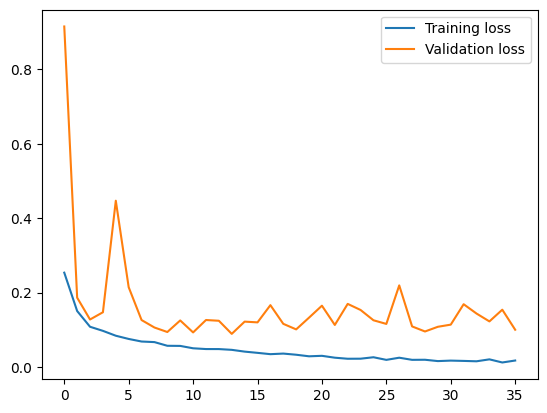

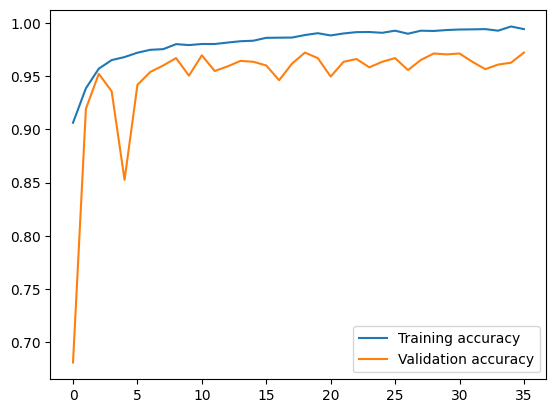

RESULTADOS EN TEST:
Pérdida en test: 0.07513447105884552
Accuracy en test: 0.9709201455116272


In [ ]:
model_defrost_data_augmentation_lr_SGD_III(10, 35, 'densenet201')

### Descongelamos los 4 últimos bloques densos (conv5, conv4, conv3)

In [ ]:
def model_defrost_data_augmentation_lr_SGD_IIII(epochs_frozen, epochs_defrost, dense_type):

    ############################################################
    ### Transfer learning
    ############################################################

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ])

    # map aplica la función pasada como primer argumento a todos los elemetos
    # del dataset y devuelve un nuevo dataset que contiene los elementos
    # transformados
    train_aug = train.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    densenet = cargaDenseNet(dense_type)

    densenet.trainable = False

    inputs = keras.Input(shape=(image_size,image_size,channels))
    x = preprocess_input(inputs)
    x = densenet(x, training = False)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    hist = model.fit(
        train_aug,
        # batch_size = batch_size,
        epochs = epochs_frozen,
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist)

    print('RESULTADOS EN TEST:')
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])

    del score

    ############################################################
    ### Fine-tuning
    ############################################################

    total_epochs = epochs_frozen + epochs_defrost
    
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    my_layer = model.get_layer(dense_type)
    my_layer.trainable = True

    for layer in my_layer.layers:
        if ('conv4' in layer.name) or ('conv5' in layer.name) or ('conv3' in layer.name) or ('conv2' in layer.name):
            #print(layer.name)
            layer.trainable = True
        else:
            layer.trainable = False

    # Cuantas capas tiene el modelo DenseNet121
    # print("Número de capas de DenseNet121: ", len(densenet.layers))

    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True, momentum = 0.9),
        metrics=["accuracy"]
    )

    model.summary()

    hist_fine = model.fit(
        train_aug,
        epochs = total_epochs,
        callbacks=[model_checkpoint_callback],
        initial_epoch = hist.epoch[-1],
        validation_data = validation,
        verbose = 1
    )

    mostrarEvolucion(hist_fine)

    print('RESULTADOS EN TEST:')

    model.load_weights(checkpoint_filepath)
    score = model.evaluate(test, verbose=0)
    print('Pérdida en test:', score[0])
    print('Accuracy en test:', score[1])
    
    # model.save(dense_type + '-IIII.h5')


    del model, score, hist, densenet, hist_fine

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                           

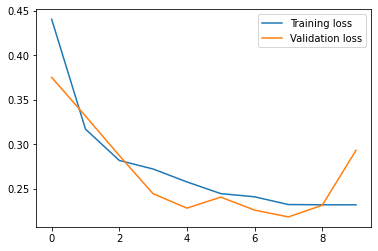

RESULTADOS EN TEST:
Pérdida en test: 0.27293840050697327
Accuracy en test: 0.8758680820465088
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (N

RESULTADOS EN TEST:
Pérdida en test: 0.08932308107614517
Accuracy en test: 0.9691840410232544


In [ ]:
model_defrost_data_augmentation_lr_SGD_IIII(10, 35, 'densenet201')